## Task description

On the current version of the landing page, the user first selects a retailer, goes to the catalog, searches for the goods he needs, and only then can he find out that there may not be a selected store at his address. We want to test the hypothesis that choosing an address before the store selection stage will help to avoid “wry” scenarios without increasing bounces from the landing itself.

#### Groups

1 - control (without any changes)

2 - test, first the user specifies the address, then selects the store.

#### Metrics

The main metrics on the basis of which we will make a decision:

- Conversion to adding to the cart

https://cool-abrosaurus-5ca.notion.site/30-2021-9775b6f3f6754fbc8d9d4fd3ab8717b1

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import scipy
from scipy import stats

In [5]:
df = pd.read_csv('AB Test Hit.csv')
df.head()

,hit_at,anonymous_id,group,device_type,browser,os
0,2020-11-30 04:21:38.616 UTC,3e05a2dc-3922-4caf-b837-08fcb337c82e,default,desktop,IE,Windows
1,2020-12-01 20:24:04.363 UTC,7f00b6ca-7938-4866-a323-c520838f5ef9,default,desktop,IE,Windows
2,2020-11-28 20:16:52.901 UTC,91e9900e-2cc6-4362-92b4-9e6712a6918e,address_first,desktop,IE,Windows
3,2020-11-29 13:29:40.557 UTC,616dd5e8-dee2-47aa-9d80-0dfadcf1922f,default,desktop,IE,Windows
4,2020-11-27 14:56:29.471 UTC,64734da4-d9f3-4d53-b401-4d0819a6e5fb,default,desktop,IE,Windows


# 1. Sanity check, cleaning data

Let's verify that the experiment was conducted as expected

In [6]:
df['group'].value_counts()

default          446474
address_first     56310
Name: group, dtype: int64

In [7]:
df.shape

(502784, 6)

In [8]:
df['anonymous_id'].nunique()

489019

### 1.1. Users in Test and Control groups

In [9]:
print("We have {} duplicating ids. Let's fix it.".format(df.shape[0] - df['anonymous_id'].nunique()))

We have 13765 duplicating ids. Let's fix it.


In [10]:
num_ids = df.groupby(by = ['anonymous_id', 'group'])['anonymous_id'].agg(cnt_ids = 'count').reset_index()

In [11]:
duplicated_ids = num_ids[num_ids['cnt_ids'] > 1]
duplicated_ids.sort_values(by = 'cnt_ids')

,anonymous_id,group,cnt_ids
0,00000782-154a-4159-ab12-6c34b658e375,default,2
318104,a6651839-60df-4862-b377-05fa30540c68,default,2
318227,a6786cf6-0c94-452e-ad22-eae70b3d17fd,default,2
318283,a67fa796-62f7-4eaf-80a6-20aa325147f7,default,2
318385,a68a2a0a-da85-45af-ab57-cac58167f4bd,default,2
...,...,...,...
356133,ba5239f5-1115-4caa-aef2-242a9c039b12,default,14
13308,06eaec3d-511a-4794-92ea-a19efaaf7f19,default,15
56718,1dea1cc9-72c0-4bee-bdb6-c59faacd72ba,default,15
360669,bcaa113d-c128-443f-9ede-2736847e1969,default,15


In [12]:
drop_ids = set(duplicated_ids[duplicated_ids['anonymous_id'].duplicated()]['anonymous_id'])

In [13]:
print('User ids that are in both groups: ', drop_ids, len(drop_ids))

User ids that are in both groups:  {'42b96e58-6e9a-46eb-ac13-5628e3655e07', 'bd2d24ed-057d-46f8-a723-3d76617fc745', 'fb24fbdb-076a-434e-843b-483286468588', '6804b672-1956-4b87-8eb7-bd1cf167e699', 'c222fa89-1c1b-49fb-ab93-333aacabcf0d', '73a49ded-4192-4e54-ae49-2c7235e931fa', 'e082144b-f119-4a82-9cfd-ee6f70bd5601', 'cebd2043-6a3a-4f4e-9c94-258b0708bf5e'} 8


8 users are in both groups - let's drop them

other ~10000 users are duplicated in our table, but they belong to the same group. We will leave the oldest entry

In [14]:
df_cleaned = df.sort_values(by = ['anonymous_id', 'hit_at']).groupby(by = 'anonymous_id').agg('first')
df_cleaned.reset_index(inplace = True)

In [15]:
df_cleaned.shape

(489019, 6)

In [16]:
drop_indexes = df_cleaned[df_cleaned['anonymous_id'].isin(drop_ids)].index

In [17]:
df_cleaned = df_cleaned.drop(drop_indexes)
df_cleaned.shape

(489011, 6)

In [18]:
df_cleaned['anonymous_id'].nunique()

489011

Ok, now we have cleaned table with unique ids

In [19]:
df = df_cleaned

### 1.2. Time of the experiment

In [20]:
df['date'] = pd.to_datetime(df['hit_at']).dt.date

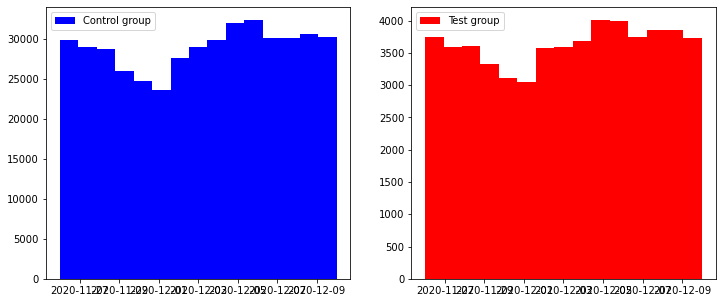

In [21]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.hist(df[df['group'] == 'default']['date'], bins = 15, color = 'b', label = 'Control group')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df[df['group'] == 'address_first']['date'], bins = 15, color = 'r', label = 'Test group')
plt.legend()

plt.show()

In [22]:
df[df['group'] == 'default']['date'].agg(['min', 'max'])

min    2020-11-26
max    2020-12-10
Name: date, dtype: object

In [23]:
df[df['group'] == 'address_first']['date'].agg(['min', 'max'])

min    2020-11-26
max    2020-12-10
Name: date, dtype: object

The experiment lasted 15 days. The distributions of Control and Test groups by dates look the same.

### 1.3. Distributions of device_type and os in Control and Test groups

In [24]:
device_types_control = df[df['group'] == 'default']['device_type'].value_counts()
device_types_test = df[df['group'] == 'address_first']['device_type'].value_counts()

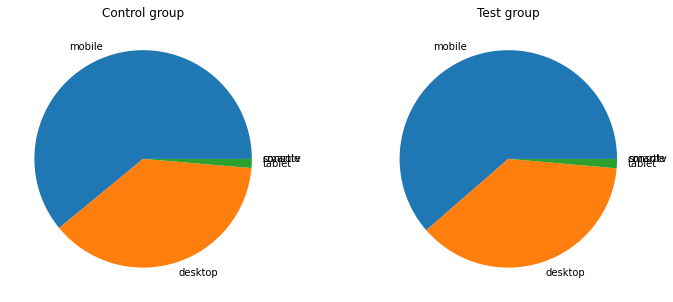

In [25]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1).set_title('Control group')
plt.pie(device_types_control, labels = device_types_control.index)

plt.subplot(1, 2, 2).set_title('Test group')
plt.pie(device_types_test, labels = device_types_test.index)
plt.show()

In [26]:
os_control = df[df['group'] == 'default']['os'].value_counts().reset_index()
os_test = df[df['group'] == 'address_first']['os'].value_counts().reset_index()
os_control.set_axis(['os', 'cnt'], axis = 1, inplace = True)
os_test.set_axis(['os', 'cnt'], axis = 1, inplace = True)

In [27]:
threshold_control = 0.01*os_control['cnt'].sum()
threshold_test = 0.01*os_test['cnt'].sum()

In [28]:
os_control['os'] = os_control.apply(lambda x: x.os if (x.cnt > threshold_control) else 'other', axis = 1)
os_test['os'] = os_test.apply(lambda x: x.os if (x.cnt > threshold_test) else 'other', axis = 1)

In [29]:
os_control = os_control.groupby(by = 'os').sum().reset_index()
os_test = os_test.groupby(by = 'os').sum().reset_index()

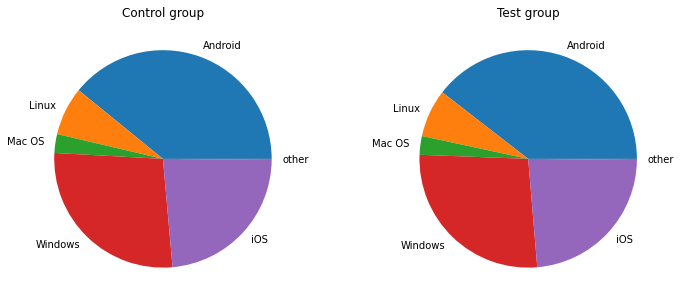

In [30]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1).set_title('Control group')
plt.pie(os_control['cnt'], labels = os_control['os'])

plt.subplot(1, 2, 2).set_title('Test group')
plt.pie(os_test['cnt'], labels = os_test['os'])

plt.show()

Experiment is conducted as expected

# 2. Preparing data from other tables for analysis

### 2.1. Product added

In [31]:
df_product_added = pd.read_csv('Product Added.csv')
df_product_added.head()

,timestamp,anonymous_id
0,2020-12-09 20:51:32.429 UTC,e2d50ef1-0667-4da4-88ef-ecbdd7c6a73a
1,2020-12-09 19:39:10.216 UTC,bb5ca977-97f4-4ec8-8a71-fe206108917b
2,2020-12-09 21:53:08.999 UTC,8e965f2b-7da0-4efb-84f5-f205956e8c30
3,2020-12-09 19:46:22.307 UTC,bb5ca977-97f4-4ec8-8a71-fe206108917b
4,2020-12-09 22:16:13.379 UTC,8e965f2b-7da0-4efb-84f5-f205956e8c30


In [32]:
df_product_added.shape

(1150060, 2)

In [33]:
df_product_added = df_product_added.merge(df[['anonymous_id', 'hit_at']], how = 'left', on = 'anonymous_id')

In [34]:
df_product_added.head()

,timestamp,anonymous_id,hit_at
0,2020-12-09 20:51:32.429 UTC,e2d50ef1-0667-4da4-88ef-ecbdd7c6a73a,2020-12-07 06:08:33.61 UTC
1,2020-12-09 19:39:10.216 UTC,bb5ca977-97f4-4ec8-8a71-fe206108917b,2020-11-26 17:07:10.428 UTC
2,2020-12-09 21:53:08.999 UTC,8e965f2b-7da0-4efb-84f5-f205956e8c30,2020-11-30 16:51:42.402 UTC
3,2020-12-09 19:46:22.307 UTC,bb5ca977-97f4-4ec8-8a71-fe206108917b,2020-11-26 17:07:10.428 UTC
4,2020-12-09 22:16:13.379 UTC,8e965f2b-7da0-4efb-84f5-f205956e8c30,2020-11-30 16:51:42.402 UTC


In [35]:
df_product_added = df_product_added[df_product_added['timestamp'] > df_product_added['hit_at']]

In [36]:
df_product_added = df_product_added.groupby(by = 'anonymous_id')['timestamp'].count().to_frame('num_of_products_added').reset_index()

In [37]:
df_product_added.head()

,anonymous_id,num_of_products_added
0,00000782-154a-4159-ab12-6c34b658e375,34
1,00021d91-c65e-4049-9ae1-7d64702c8c12,20
2,0003ca8f-bb3f-4954-84c7-1fbf2353a454,9
3,0004225d-57d6-44af-8f41-93958b41fbc4,8
4,00048409-3554-4049-907b-88401056d5b0,9


In [38]:
df = df.merge(df_product_added, how = 'left', on = 'anonymous_id')

In [39]:
df['num_of_products_added'].fillna(0, inplace = True)

In [40]:
df['is_product_added'] = df['num_of_products_added'].apply(lambda x: True if (x > 0) else False)

### 2.2. Order Completed

In [41]:
df_order = pd.read_csv('Order Completed.csv')
df_order.head()

,timestamp,anonymous_id,order_sum
0,2020-12-10 09:23:09.195 UTC,3343c486-8d88-44a6-87e5-5c1631e3db3d,3746.231921
1,2020-12-10 13:11:07.166 UTC,c4491ab9-e59e-444e-bd92-c462830e4b5b,1619.242047
2,2020-12-10 15:42:29.153 UTC,82f2bac5-8c73-4ed2-8022-27fa0dbd8fc2,2439.605901
3,2020-12-10 17:04:52.163 UTC,fffb6076-550e-445e-8227-68219671113a,1288.577888
4,2020-12-10 21:25:58.898 UTC,00e258f1-7908-467e-a66e-d42284ea3f2d,6875.955129


In [42]:
df_order.shape

(16650, 3)

In [43]:
df_order = df_order.merge(df[['anonymous_id', 'hit_at']], how = 'left', on = 'anonymous_id')

In [44]:
df_order = df_order[df_order['timestamp'] > df_order['hit_at']]

In [45]:
df_order.shape

(15446, 4)

In [46]:
df_order['anonymous_id'].nunique()

8618

In [47]:
df_order = df_order.groupby(by = 'anonymous_id').agg(order_sum = ('order_sum', 'sum'), order_cnt = ('order_sum', 'count')).reset_index()

In [48]:
df_order['is_order_completed'] = True

In [49]:
df = df.merge(df_order, how = 'left', on = 'anonymous_id')

In [50]:
df['order_sum'].fillna(0, inplace = True)
df['order_cnt'].fillna(0, inplace = True)
df['is_order_completed'].fillna(False, inplace = True)

# 3. Analysing Data

## 3.1. Conversion rates

In [51]:
df.head(2)

,anonymous_id,hit_at,group,device_type,browser,os,date,num_of_products_added,is_product_added,order_sum,order_cnt,is_order_completed
0,00000782-154a-4159-ab12-6c34b658e375,2020-11-28 07:46:52.198 UTC,default,mobile,Chrome,Android,2020-11-28,34.0,True,0.0,0.0,False
1,00001104-4c72-4f48-bb8c-ace2ded63f8b,2020-12-05 10:01:51.373 UTC,default,desktop,Chrome,Windows,2020-12-05,0.0,False,0.0,0.0,False


In [52]:
df_result = df.groupby(by = 'group').agg(total_hits = ('is_product_added', 'count'), is_products_added = ('is_product_added', 'sum'), 
                            is_order_completed = ('is_order_completed', 'sum'), mean_products_added = ('num_of_products_added', 'mean')).reset_index()

In [53]:
df_result['cr_products_added'] = df_result['is_products_added']/df_result['total_hits']
df_result['cr_order'] = df_result['is_order_completed']/df_result['total_hits']
df_result

,group,total_hits,is_products_added,is_order_completed,mean_products_added,cr_products_added,cr_order
0,address_first,54510,5280,998,2.215722,0.096863,0.018309
1,default,434501,38156,7620,2.136628,0.087816,0.017537


In [54]:
df_result_order_sum = df[df['order_sum'] > 0].groupby(by = 'group').agg(mean_order = ('order_sum', 'mean'), median_order = ('order_sum', 'median')).reset_index()
df_result_order_sum

,group,mean_order,median_order
0,address_first,11239.049608,6635.975758
1,default,11263.323674,6275.947395


## 3.2. Hypothesis testing

### 3.2.1. Conversion rate for users to add products to a cart 

**Null Hypothesis**: The conversion rate for users to add products to a cart is the same for both groups.

**Alternative Hypothesis** : The conversion rate differs.

In [55]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1))/n1
    p2 = float(sum(sample2))/n2
    p = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / math.sqrt(p * (1-p) *(1./n1 + 1./n2))

In [56]:
def proportions_diff_z_test(z_stat):
    return 2 * (1 - scipy.stats.norm.cdf(abs(z_stat)))

In [57]:
z_stat_product_added = proportions_diff_z_stat_ind(df[df['group'] == 'default']['is_product_added'], df[df['group'] == 'address_first']['is_product_added'])

In [58]:
print('p-value: {}'.format(proportions_diff_z_test(z_stat_product_added)))

p-value: 2.581046487648564e-12


$H_0$ rejected. The conversion rate differs. p-value: 2.58e-12

### 3.2.2. Conversion rate for users to make an order

**Null Hypothesis**: The conversion rate for users to make an order is the same for both groups.

**Alternative Hypothesis**: The conversion rate differs.

In [59]:
z_stat_order_completed = proportions_diff_z_stat_ind(df[df['group'] == 'default']['is_order_completed'], df[df['group'] == 'address_first']['is_order_completed'])

In [60]:
print('p-value: {}'.format(proportions_diff_z_test(z_stat_order_completed)))

p-value: 0.1970783049582141


We can not reject $H_0$ at significant level of 0.05 (p-value = 0.197)

### 3.2.3. Order price 

In [71]:
#scipy.stats.probplot(df[(df['order_sum'] > 0) & (df['group'] == 'address_first')]['order_sum'], dist = 'norm', plot = plt)

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [63]:
scipy.stats.mannwhitneyu(df[(df['group'] == 'default') & (df['order_sum'] > 0)]['order_sum'], df[(df['group'] == 'address_first') & (df['order_sum'] > 0)]['order_sum'])

MannwhitneyuResult(statistic=3759639.0, pvalue=0.5630563518377296)

We can not reject $H_0$. Order price didn't changed statistically significant, pvalue = 0.56

In [64]:
scipy.stats.mannwhitneyu(df[(df['group'] == 'default')]['order_sum'], df[(df['group'] == 'address_first')]['order_sum'])

MannwhitneyuResult(statistic=11833149115.0, pvalue=0.19501428401097576)

#### Bootstrap. Median changes.

In [65]:
def get_bootstrap_samples(data, n_samples, len_sample):
    indices = np.random.randint(0, len(data), (n_samples, len_sample))
    samples = data[indices]
    return samples

In [66]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100*alpha/2., 100*(1 - alpha/2.)])
    return boundaries

In [67]:
order_control = df[(df['group'] == 'default') & (df['order_sum'] > 0)]['order_sum'].values
order_test = df[(df['group'] == 'address_first') & (df['order_sum'] > 0)]['order_sum'].values

In [68]:
order_control_median = list(map(np.median, get_bootstrap_samples(order_control, 10000, len(order_control))))
order_test_median = list(map(np.median, get_bootstrap_samples(order_test, 10000, len(order_test))))

delta_median_scores = list(map(lambda x: x[1] - x[0], zip(order_control_median, order_test_median)))

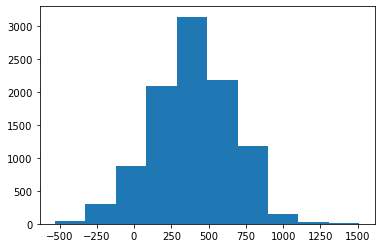

In [69]:
plt.hist(delta_median_scores)
plt.show()

In [70]:
stat_intervals(delta_median_scores, 0.05)

array([-166.08921627,  863.02747809])

At significant level of 0.05, we can not confirm that median of order price has changed.

# 4. Conclusion

According to the metric proposed (conversion to adding to the cart), the experiment can indeed be considered successful:
+ conversion increased from 0.088 to 0.097, statistically significantly, p-value: 2.58e-12

**BUT** if we use more important metrics for business: 
+ conversion to order
+ average order price

they have not changed statistically significantly and the experiment can be considered unsuccessful.